In [2]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
import sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from tqdm import tqdm
import json
from pycocotools.mask import decode
import numpy as np
from pycocotools.mask import decode
import cv2 

import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

np.random.seed(3)

In [3]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=150):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

def select_tray_mask(masks):
    area_gt = 120000
    min_area_diff = 100000000
    selected_mask = None
    for mask in masks:
        area_mask = np.sum(mask)
        area_diff = abs(area_mask - area_gt)
        if area_diff < min_area_diff:
            selected_mask = mask
            area_diff_min = area_diff
    
    return selected_mask

In [4]:
sam2_checkpoint = "/home/user/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cpu")

predictor = SAM2ImagePredictor(sam2_model)

/home/parth/snaak/projects/vision_venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/sam2/checkpoints/sam2.1_hiera_small.pt'

In [ ]:
dir_path = "../../data_collection/assembly/tray"
img_name = "image_20250227-004818.png"
img_path = os.path.join(dir_path, img_name)

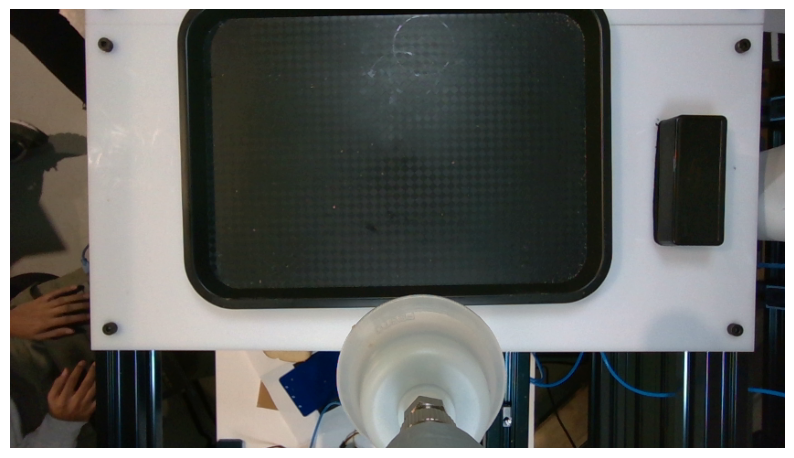

In [ ]:
# Diplay image

image = Image.open(img_path)
image = np.array(image.convert("RGB"))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
print(image.shape)

(480, 848, 3)


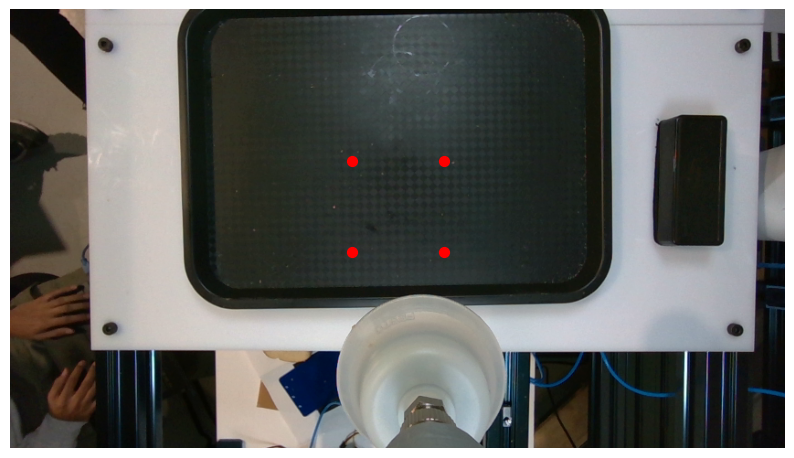

In [ ]:
img_h, img_w, c = image.shape
img_h -= 50
variance = 50

p1 = [img_w // 2 - variance, img_h // 2 - variance]
p2 = [img_w // 2 + variance, img_h // 2 - variance]
p3 = [img_w // 2 - variance, img_h // 2 + variance]
p4 = [img_w // 2 + variance, img_h // 2 + variance]

input_points = np.array([p1, p2, p3, p4])
input_labels = np.array([1, 1, 1, 1])

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.scatter(input_points[:, 0], input_points[:, 1], color="red", s=50, label="Points")
plt.axis('off')
plt.show()  

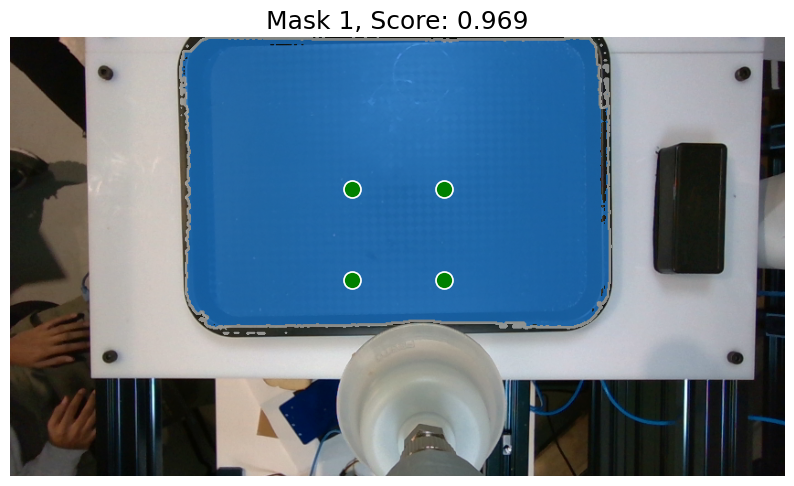

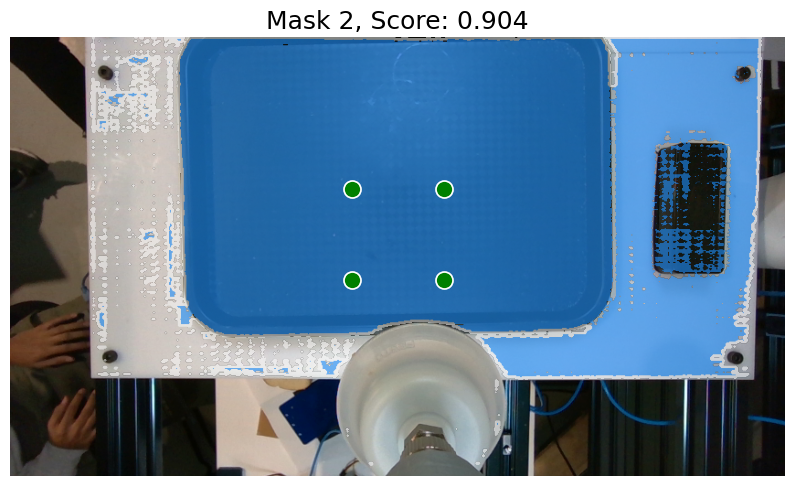

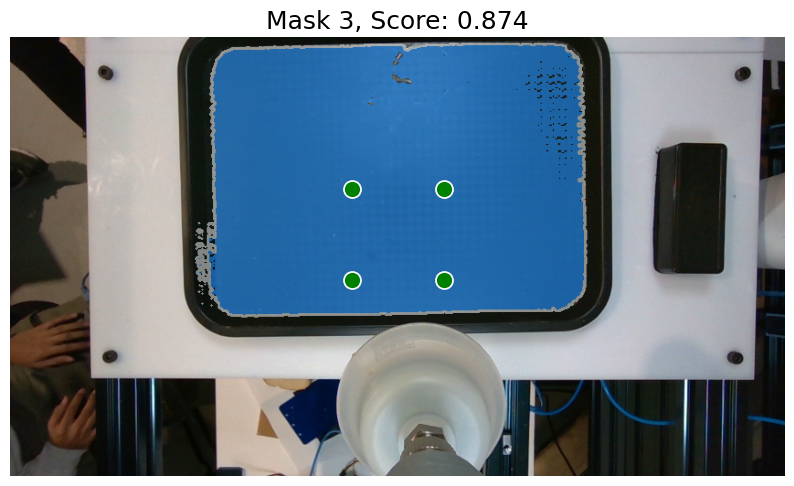

In [ ]:
predictor.set_image(image)

masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_points, input_labels=input_labels, borders=True)

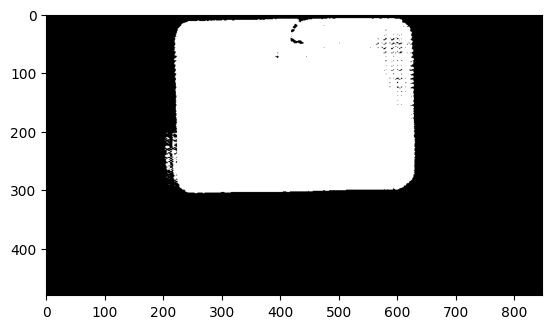

In [ ]:
# Apply area based filtering

selected_mask = select_tray_mask(masks)
selected_mask = selected_mask * 255
plt.imshow(selected_mask, cmap="gray")

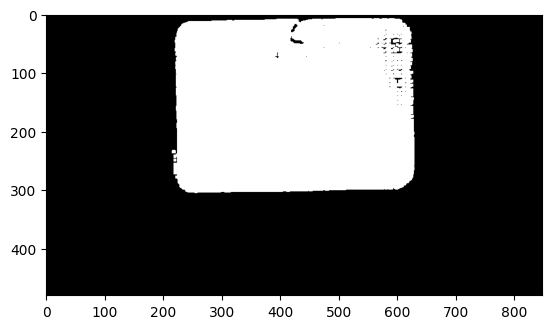

In [ ]:
def process_mask(mask):
    mask_new = mask.copy()
    kernel = np.ones((5, 5), np.uint8)
    mask_new = cv2.erode(mask_new, kernel, iterations=1)
    mask_new = cv2.dilate(mask_new, kernel, iterations=1)
    return mask_new

plt.imshow(process_mask(selected_mask), cmap="gray")

True

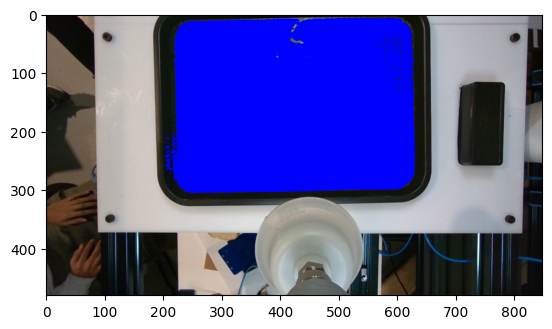

In [ ]:
# Create result plot
color = (0, 0, 255)
colored_image = np.zeros_like(image)
colored_image[:] = color

# Use the mask to blend the coloured image with the original
result = np.where(selected_mask[:, :, None] == 255, colored_image, image)

# Save or display the result
plt.imshow(result)

cv2.imwrite(f"{img_name.split('.')[0]}_result.jpg", result)

In [ ]:
for img_name in os.listdir(dir_path):
    img_path = os.path.join(dir_path, img_name)
    image = Image.open(img_path)
    image = np.array(image.convert("RGB"))
    
    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]

    selected_mask = select_tray_mask(masks)
    selected_mask = process_mask(selected_mask)
    selected_mask = selected_mask * 255

    # Create result plot
    color = (0, 0, 255)
    colored_image = np.zeros_like(image)
    colored_image[:] = color

    # Use the mask to blend the coloured image with the original
    result = np.where(selected_mask[:, :, None] == 255, colored_image, image)

    # Save or display the result
    # plt.imshow(result)

    cv2.imwrite(f"{img_name.split('.')[0]}_result.jpg", result)